In [2]:
## import packages
import pandas as pd
import scorecardpy as sc

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV

from optbinning import BinningProcess
from optbinning.binning.binning_statistics import BinningTable
from optbinning import Scorecard
from optbinning.scorecard import Counterfactual, plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring
from sklearn.pipeline import Pipeline

In [3]:
path = "../dagster-scorecard/data/outputs/application_selected_features.csv"
df = pd.read_csv(path)
df.set_index("id", inplace=True)

## display
df

,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
id,,,,,,,,,,,,,,
55320288,354.89,9386.86,25.50,0,44.0,18100,6,225,B,Not Verified,f,1,RENT,0
41930439,422.67,9567.06,36.93,0,81.3,21100,10,179,C,Verified,f,0,MORTGAGE,0
43801439,62.84,1492.56,16.92,0,17.1,25600,10,132,B,Verified,f,0,MORTGAGE,0
598481,197.95,5575.04,25.67,0,41.1,30100,3,311,B,Source Verified,w,1,RENT,0
55847195,312.86,8492.75,34.74,0,20.2,35800,6,129,A,Not Verified,w,2,MORTGAGE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46446945,543.44,22402.01,27.71,0,79.6,103100,9,340,B,Source Verified,w,0,MORTGAGE,0
60920737,66.71,1859.89,22.45,1,44.7,20900,4,404,C,Not Verified,w,0,MORTGAGE,0
60762054,275.96,7458.56,28.58,0,76.9,4400,4,169,C,Source Verified,f,1,RENT,0


In [4]:
def is_dichotomic(column):
            import numpy as np
            unique_values = column.dropna().unique()
            return len(unique_values) == 2 and np.issubdtype(unique_values.dtype, np.integer)

In [5]:
## prep features dan target
feature_names = list(df.copy().drop(labels=["credit_event"], axis=1).columns)
X = df[feature_names]
y = df["credit_event"].values

## splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666, stratify=y
)

## cek variabel dichotomic
dichotomic_feats = [col for col in df.columns if col != 'credit_event' and is_dichotomic(df[col])]

In [6]:
binning_process = BinningProcess(feature_names,
                        categorical_variables=dichotomic_feats,
                        verbose=True
                        )

binning_process.fit(X_train, y_train)

2024-10-28 08:09:10,490 | INFO : Binning process started.
2024-10-28 08:09:10,492 | INFO : Options: check parameters.
2024-10-28 08:09:10,494 | INFO : Dataset: number of samples: 38718.
2024-10-28 08:09:10,496 | INFO : Dataset: number of variables: 13.
2024-10-28 08:09:10,496 | INFO : Options: number of jobs (cores): 1.
2024-10-28 08:09:10,496 | INFO : Binning variable (0 / 13): last_pymnt_amnt.
2024-10-28 08:09:10,871 | INFO : Binning variable (1 / 13): out_prncp_inv.
2024-10-28 08:09:11,102 | INFO : Binning variable (2 / 13): dti.
2024-10-28 08:09:11,319 | INFO : Binning variable (3 / 13): months_since_last_pymnt_d_last_credit_pull_d.
2024-10-28 08:09:11,335 | INFO : Binning variable (4 / 13): revol_util.
2024-10-28 08:09:11,412 | INFO : Binning variable (5 / 13): total_rev_hi_lim.
2024-10-28 08:09:11,543 | INFO : Binning variable (6 / 13): months_since_issue_d_last_credit_pull_d.
2024-10-28 08:09:11,606 | INFO : Binning variable (7 / 13): months_since_earliest_cr_line.
2024-10-28 08

BinningProcess(categorical_variables=[],
               variable_names=['last_pymnt_amnt', 'out_prncp_inv', 'dti',
                               'months_since_last_pymnt_d_last_credit_pull_d',
                               'revol_util', 'total_rev_hi_lim',
                               'months_since_issue_d_last_credit_pull_d',
                               'months_since_earliest_cr_line', 'grade',
                               'verification_status', 'initial_list_status',
                               'inq_last_6mths', 'home_ownership'],
               verbose=True)

In [7]:
X_train_binned = binning_process.transform(X_train,  metric="woe", check_input=True).reset_index(drop=False)
display(X_train_binned.info(),
        X_train_binned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38718 entries, 0 to 38717
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            38718 non-null  int64  
 1   last_pymnt_amnt                               38718 non-null  float64
 2   out_prncp_inv                                 38718 non-null  float64
 3   dti                                           38718 non-null  float64
 4   months_since_last_pymnt_d_last_credit_pull_d  38718 non-null  float64
 5   revol_util                                    38718 non-null  float64
 6   total_rev_hi_lim                              38718 non-null  float64
 7   months_since_issue_d_last_credit_pull_d       38718 non-null  float64
 8   months_since_earliest_cr_line                 38718 non-null  float64
 9   grade                                         38718 non-null 

None

,id,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership
0,48161474,-0.051915,0.382351,0.255422,2.349256,0.127820,0.356059,-0.523335,0.230244,1.633634,0.522860,0.347303,-0.205047,0.099934
1,40372752,-0.051915,0.262982,0.044927,2.349256,-0.226704,0.305091,-0.860744,0.057185,-0.660935,0.522860,-0.398723,-0.205047,-0.236538
2,50607223,-0.051915,0.262982,0.255422,2.349256,0.127820,0.305091,-0.150058,0.073178,0.905829,-0.059896,0.347303,0.237285,0.099934
3,66045113,-0.051915,0.353734,0.213369,-1.339272,-0.026882,0.305091,2.278665,-0.093236,0.905829,0.522860,0.347303,0.237285,0.211960
4,38415208,2.983279,-1.765508,0.044927,-1.339272,-0.026882,-0.003525,-0.705040,-0.093236,0.905829,-0.059896,-0.398723,0.237285,0.099934


In [8]:
## training
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg.fit(X_train_binned, y_train)

y_pred = logreg.predict(X_train_binned)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88     38012
           1       0.07      0.92      0.14       706

    accuracy                           0.79     38718
   macro avg       0.54      0.85      0.51     38718
weighted avg       0.98      0.79      0.86     38718



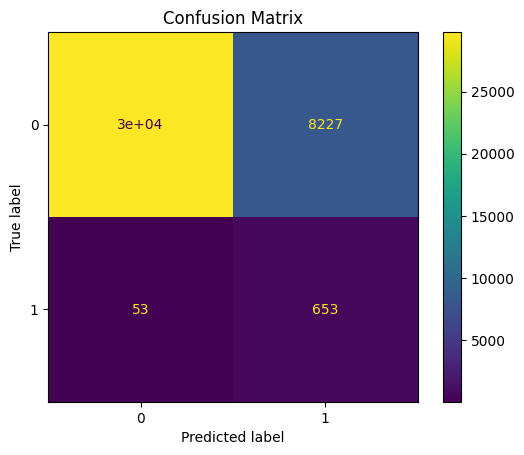

In [9]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [10]:
## predict di test
## transform dulu
X_test_binned = binning_process.transform(X_test,  metric="woe", check_input=True).reset_index(drop=False)
display(X_test_binned.info(),
        X_test_binned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9680 non-null   int64  
 1   last_pymnt_amnt                               9680 non-null   float64
 2   out_prncp_inv                                 9680 non-null   float64
 3   dti                                           9680 non-null   float64
 4   months_since_last_pymnt_d_last_credit_pull_d  9680 non-null   float64
 5   revol_util                                    9680 non-null   float64
 6   total_rev_hi_lim                              9680 non-null   float64
 7   months_since_issue_d_last_credit_pull_d       9680 non-null   float64
 8   months_since_earliest_cr_line                 9680 non-null   float64
 9   grade                                         9680 non-null   f

None

,id,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership
0,65312841,0.057516,0.903150,0.255422,2.349256,-0.026882,-0.003525,2.278665,0.230244,0.905829,0.522860,0.347303,-0.450425,0.211960
1,66630410,-0.051915,0.382351,0.044927,2.349256,0.127820,0.098303,2.417532,0.230244,0.130005,0.522860,0.347303,-0.450425,0.099934
2,38464969,-0.051915,0.353734,0.255422,2.349256,0.127820,-0.003525,-0.968714,0.057185,-1.068392,-0.059896,-0.398723,-0.205047,-0.236538
3,57695314,-0.481391,0.042594,0.255422,-1.339272,-0.026882,-0.003525,0.869743,0.230244,-1.068392,-0.266983,0.347303,0.237285,0.211960
4,54534805,-0.051915,0.353734,-0.413839,2.349256,-0.026882,-0.336403,0.104068,-0.093236,0.130005,-0.266983,0.347303,0.237285,0.211960


In [11]:
y_pred = logreg.predict(X_test_binned)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      9504
           1       0.08      0.97      0.14       176

    accuracy                           0.79      9680
   macro avg       0.54      0.87      0.51      9680
weighted avg       0.98      0.79      0.86      9680



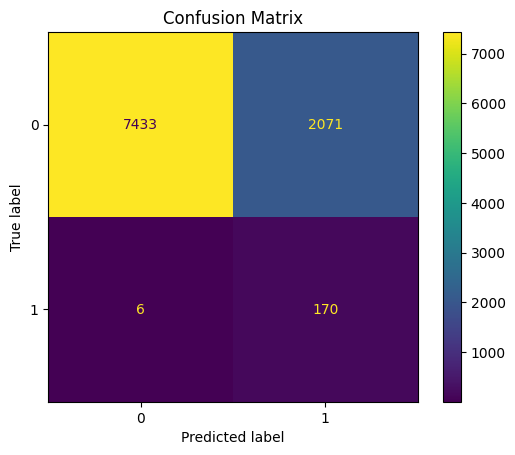

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix')
plt.show()

Optimize

In [35]:
## load data yg sudah ditransform ke woe
path = "../dagster-scorecard/data/outputs/application_selected_features.csv"
df = pd.read_csv(path)
# df.set_index("id", inplace=True)

## display
df

,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,id,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
0,354.89,9386.86,25.50,0,44.0,18100,55320288,6,225,B,Not Verified,f,1,RENT,0
1,422.67,9567.06,36.93,0,81.3,21100,41930439,10,179,C,Verified,f,0,MORTGAGE,0
2,62.84,1492.56,16.92,0,17.1,25600,43801439,10,132,B,Verified,f,0,MORTGAGE,0
3,197.95,5575.04,25.67,0,41.1,30100,598481,3,311,B,Source Verified,w,1,RENT,0
4,312.86,8492.75,34.74,0,20.2,35800,55847195,6,129,A,Not Verified,w,2,MORTGAGE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48393,543.44,22402.01,27.71,0,79.6,103100,46446945,9,340,B,Source Verified,w,0,MORTGAGE,0
48394,66.71,1859.89,22.45,1,44.7,20900,60920737,4,404,C,Not Verified,w,0,MORTGAGE,0
48395,275.96,7458.56,28.58,0,76.9,4400,60762054,4,169,C,Source Verified,f,1,RENT,0
48396,700.42,19529.01,7.82,0,79.4,27900,59679287,3,208,C,Source Verified,w,2,MORTGAGE,0


In [36]:
## prep features dan target
feature_names = list(df.copy().drop(labels=["credit_event", "id"], axis=1).columns)
X = df[feature_names]
y = df["credit_event"].values

## splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666, stratify=y
)

In [37]:
display(X_train.shape, X_test.shape)

(38718, 13)

(9680, 13)

In [38]:
binning_process = BinningProcess(feature_names)
pipeline = Pipeline(steps=[
    ("binning_process", binning_process),
    ("estimator", LogisticRegression(random_state=666, solver="liblinear"))
])

In [39]:
from scipy.stats import uniform

params = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.01, 0.1, 1, 10],
    # 'estimator__l1_ratio': uniform(loc=0, scale=1),  ## cuma relevant untuk elasticnet
    'estimator__class_weight': ['balanced']
}

search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=5
)

search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('binning_process',
                                        BinningProcess(variable_names=['last_pymnt_amnt',
                                                                       'out_prncp_inv',
                                                                       'dti',
                                                                       'months_since_last_pymnt_d_last_credit_pull_d',
                                                                       'revol_util',
                                                                       'total_rev_hi_lim',
                                                                       'months_since_issue_d_last_credit_pull_d',
                                                                       'months_since_earliest_cr_line',
                                                                       'grade',
                                                                       'verification_status',
                                                                       'initial_list_status',
                                                                       'inq_last_6mths',
                                                                       'home_ownership'])),
                                       ('estimator',
                                        LogisticRegression(random_state=666,
                                                           solver='liblinear'))]),
             param_grid={'estimator__C': [0.01, 0.1, 1, 10],
                         'estimator__class_weight': ['balanced'],
                         'estimator__penalty': ['l1', 'l2']})

In [40]:
search.cv_results_

{'mean_fit_time': array([1.50829039, 1.42656336, 1.44327135, 1.42367439, 1.47588072,
        1.4916101 , 1.46349764, 1.50969954]),
 'std_fit_time': array([0.20700958, 0.18606903, 0.1864434 , 0.1973478 , 0.17998473,
        0.21373472, 0.20902275, 0.17950955]),
 'mean_score_time': array([0.01302576, 0.01554403, 0.01423707, 0.00965695, 0.01466179,
        0.01405225, 0.01181865, 0.01735988]),
 'std_score_time': array([0.00590743, 0.00487987, 0.00578657, 0.00514974, 0.00172184,
        0.00535532, 0.0057362 , 0.00661469]),
 'param_estimator__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value=1e+20),
 'param_estimator__class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
            

In [41]:
search.best_estimator_

Pipeline(steps=[('binning_process',
                 BinningProcess(variable_names=['last_pymnt_amnt',
                                                'out_prncp_inv', 'dti',
                                                'months_since_last_pymnt_d_last_credit_pull_d',
                                                'revol_util',
                                                'total_rev_hi_lim',
                                                'months_since_issue_d_last_credit_pull_d',
                                                'months_since_earliest_cr_line',
                                                'grade', 'verification_status',
                                                'initial_list_status',
                                                'inq_last_6mths',
                                                'home_ownership'])),
                ('estimator',
                 LogisticRegression(C=10, class_weight='balanced', penalty='l1',
                                    random_state=666, solver='liblinear'))])

In [42]:
best_logreg = search.best_estimator_

y_pred = best_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      9504
           1       0.11      0.90      0.20       176

    accuracy                           0.87      9680
   macro avg       0.56      0.88      0.57      9680
weighted avg       0.98      0.87      0.92      9680



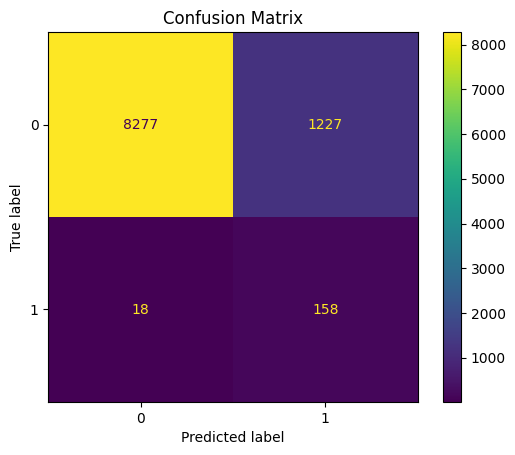

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [14]:
from scipy.stats import uniform

binning_process = BinningProcess(feature_names)
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=LogisticRegression(solver="liblinear", random_state=666)
)

params = {
    'estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'estimator__C': uniform(loc=0.1, scale=10),
    'estimator__l1_ratio': uniform(loc=0, scale=1),  ## cuma relevant untuk elasticnet
    'estimator__class_weight': ['balanced']
}

## set strategi cv (stratified)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

scorecard_search = RandomizedSearchCV(
    estimator=scorecard,
    param_distributions=params,
    scoring="roc_auc",
    cv=cv,
    random_state=666
)

scorecard_search.fit(X_train, y_train)

d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = me

KeyboardInterrupt: 

In [ ]:


regressor = Pipeline(steps=[('binning_process', binning_process),
                     ('regressor', LogisticRegression())])


param_distributions = {
    'regressor__solver': ['liblinear'],
    'regressor__penalty': ['l1', 'l2', 'elasticnet'],
    'regressor__C': uniform(loc=0.1, scale=10),
    'regressor__l1_ratio': uniform(loc=0, scale=1),  ## cuma relevant untuk elasticnet
    'regressor__class_weight': ['balanced']
}


## set strategi cv (stratified)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_distributions,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    n_jobs=None,
    random_state=42
)

random_search.fit(X_train, y_train)

In [ ]:
X_train_binned = binning_process.transform(X_train,  metric="woe", check_input=True).reset_index(drop=False)
display(X_train_binned.info(),
        X_train_binned.head())

training

In [ ]:
from scipy.stats import uniform

estimator = LogisticRegression(solver="lbfgs", random_state=888)

param_distributions = {
    'logistic_regression__solver': ['liblinear', 'saga'],
    'logistic_regression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logistic_regression__C': uniform(loc=0.01, scale=10),
    'logistic_regression__l1_ratio': uniform(loc=0, scale=1),  ## cuma relevant untuk elasticnet
    'logistic_regression__class_weight': [None, 'balanced']
}

## set strategi cv (stratified)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_binned, y_train)

In [ ]:
transformed_table = binning_process.fit_transform(X, y, metric="woe", check_input=True).reset_index(drop=False)
display(transformed_table.info(),
        transformed_table.head())

In [ ]:
to_merge = df[["credit_event"]].reset_index(drop=False)
to_merge.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)

transformed_applications = pd.merge(transformed_table, to_merge, left_on="id", right_on="id", how="inner") ## <-- merge by id
transformed_applications.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)
transformed_applications

training model

In [ ]:
feature_names = list(transformed_applications.copy().drop(labels=["credit_event", "id"], axis=1).columns)
X = transformed_applications[feature_names]
y = transformed_applications["credit_event"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=666, 
                                                    stratify=y)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
log = LogisticRegression()

param_grid = {
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorecard_search = GridSearchCV(
    log,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

scorecard_search.fit(X_train, y_train)

In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1